In [1]:
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# 1 task

In [4]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [41]:
class NLLLoss(torch.nn.Module):
    
    def __init__(self):
        super(NLLLoss, self).__init__()
    
    def forward(self, x):
        return -torch.mean(torch.log(x))
    
class LikelihoodModel(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(LikelihoodModel, self).__init__()
        self.theta = torch.nn.Parameter(torch.zeros(100))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
#         top = np.exp(theta[x])
#         bottom = 0
#         for theta_i in theta:
#             bottom += np.exp(theta_i)
        return torch.exp(self.theta[x]) / torch.sum(torch.exp(self.theta))

In [6]:
data = sample_data()

In [7]:
X_train_val, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.2, random_state=42)
print('X_train shape: {}, X_val shape: {}, X_test shape: {}'.format(X_train.shape, X_val.shape, X_test.shape))

X_train shape: (6400,), X_val shape: (1600,), X_test shape: (2000,)


In [8]:
bsize = 1000
trainloader=torch.utils.data.DataLoader(X_train, batch_size=bsize, shuffle=True, num_workers=3)
testloader=torch.utils.data.DataLoader(X_val, batch_size=bsize, shuffle=False, num_workers=3)

In [9]:
n_epochs = 1000
lr=0.001

model = LikelihoodModel()
loss_function = NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    train_loss_sum = 0
    n_train_batch = len(trainloader)
    model.train()
    for data in trainloader:
        optimizer.zero_grad()
        inputs = data
        outputs = model(inputs)
        loss = loss_function(outputs)
        train_loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    test_loss_sum = 0
    n_test_batch = len(testloader)
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs = data
            outputs = model(inputs)
            loss = loss_function(outputs)
            test_loss_sum += loss.item()
    print(f'\r epoch: [{epoch+1}/{n_epochs}], loss: {np.round(train_loss_sum / n_train_batch, 2)}, test_loss: {np.round(test_loss_sum / n_test_batch, 2)}', end='')
    train_losses.append(train_loss_sum / n_train_batch)
    test_losses.append(test_loss_sum / n_test_batch)

 epoch: [1000/1000], loss: 4.04, test_loss: 4.0

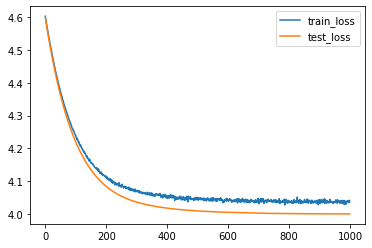

In [17]:
plot_size = n_epochs
plt.plot(list(range(plot_size)), train_losses, label='train_loss')
plt.plot(list(range(plot_size)), test_losses, label='test_loss')
plt.legend()
plt.show()

In [37]:
plot_size = 100
pred = model(torch.arange(plot_size)).tolist()
pred = np.array(pred) * 1500
data = np.zeros(plot_size)
for x in testloader.dataset:
    data[x] += 1

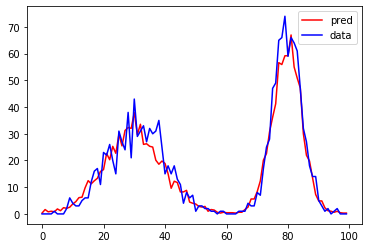

In [38]:
plt.plot(list(range(plot_size)), pred, color='r', label='pred')
plt.plot(list(range(plot_size)), data, color='b', label='data')
plt.legend()
plt.show()

# 2 Task

### 1

In [2]:
distribution = np.load('./distribution.npy')

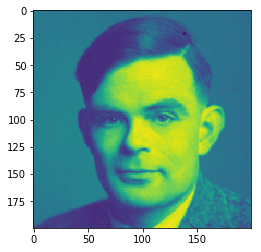

In [3]:
plt.imshow(distribution)

In [4]:
distribution.size

40000

In [5]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        n = 200
        a = torch.nn.Sequential(torch.nn.Linear(n, n), torch.nn.ReLU(), torch.nn.Dropout())
#         b = torch.nn.Sequential(torch.nn.Linear(n, n), torch.nn.ReLU(), torch.nn.Dropout())
        c = torch.nn.Sequential(torch.nn.Linear(n, n), torch.nn.Softmax(dim=1))
        self.layers = torch.nn.Sequential(a, c)
        
    def forward(self, x):
        return self.layers(x)

In [6]:
class NLLLoss(torch.nn.Module):
    
    def __init__(self):
        super(NLLLoss, self).__init__()
    
    def forward(self, x):
        return -torch.mean(torch.log(x))

class LikelihoodModel(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(LikelihoodModel, self).__init__()
        self.theta = torch.nn.Parameter(torch.zeros(200))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
#         top = np.exp(theta[x])
#         bottom = 0
#         for theta_i in theta:
#             bottom += np.exp(theta_i)
        return torch.exp(self.theta[x]) / torch.sum(torch.exp(self.theta))

In [7]:
class TaskModel(torch.nn.Module):
    def __init__(self):
        super(TaskModel, self).__init__()
        self.likelihood_model = LikelihoodModel()
        self.mlp = MLP()
        
    def forward(self, x):
        ax1 = x[:,0]
        ax2 = x[:,1]
        pred_x1 = self.likelihood_model(ax1)
        encode = torch.zeros((x.shape[0], 200))
        encode[np.arange(x.shape[0]), ax1] = 1
        pred_x2 = self.mlp(encode)[np.arange(ax2.shape[0]), ax2]
        z = pred_x1 * pred_x2
        return z

In [8]:
TaskModel()(X_val).shape

NameError: name 'X_val' is not defined

In [9]:
model = TaskModel()
loss_function = NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 10
batch_size = 1000

In [10]:
n_sample = 100000
domain = distribution.size
axes_len = np.sqrt(domain)
sample = np.random.choice(domain, size=n_sample, p=distribution.ravel())
x1 = sample % 200
x2 = sample // 200

data = []
for ax1, ax2 in zip(x1, x2):
    data.append([ax1, ax2])
data = np.array(data)

In [11]:
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [12]:
trainloader=torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
testloader=torch.utils.data.DataLoader(X_val, batch_size=batch_size, shuffle=False)

In [13]:
train_losses = []
test_losses = []
for epoch in tqdm(range(n_epochs)):
    train_losses_epoch = []
    test_losses_epoch = []
    for batch in trainloader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_function(out)
        train_losses_epoch.append(loss_function(out).item())
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for batch in testloader:
            optimizer.zero_grad()
            out = model(batch)
            loss = loss_function(out)
            test_losses_epoch.append(loss_function(out).item())
    train_losses.append(np.mean(train_losses_epoch))
    test_losses.append(np.mean(test_losses_epoch))

100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


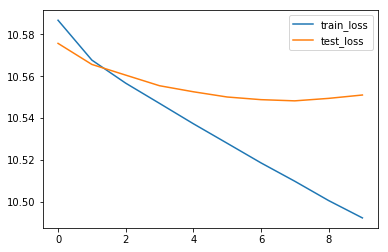

In [14]:
plot_size = n_epochs
plt.plot(list(range(plot_size)), train_losses, label='train_loss')
plt.plot(list(range(plot_size)), test_losses, label='test_loss')
plt.legend()
plt.show()

In [15]:
vals = np.array(list(range(200)))
test_d = np.transpose([np.tile(vals, len(vals)), np.repeat(vals, len(vals))])

In [16]:
out_pic_p = model(test_d)

In [17]:
out_pic_p.view(-1,200)

tensor([[1.7447e-05, 2.4148e-05, 1.6899e-05,  ..., 1.2951e-05, 1.3884e-05,
         1.3851e-05],
        [1.9461e-05, 2.2990e-05, 2.0724e-05,  ..., 1.4870e-05, 1.9780e-05,
         1.5024e-05],
        [1.6168e-05, 1.7684e-05, 1.8040e-05,  ..., 1.4666e-05, 2.1994e-05,
         1.6254e-05],
        ...,
        [1.9387e-05, 2.0331e-05, 1.4820e-05,  ..., 1.2420e-05, 1.4740e-05,
         1.6808e-05],
        [1.7481e-05, 2.0113e-05, 1.7075e-05,  ..., 1.3059e-05, 1.6369e-05,
         1.3143e-05],
        [1.8972e-05, 1.6924e-05, 1.8550e-05,  ..., 1.6583e-05, 2.4794e-05,
         1.3986e-05]], grad_fn=<ViewBackward>)

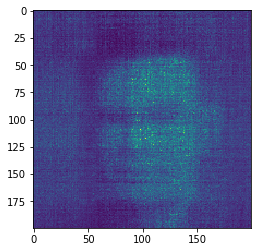

In [18]:
plt.imshow(out_pic_p.view(200,-1).detach().numpy());

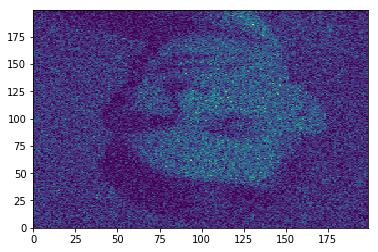

In [19]:
plt.hist2d(data[:,0], data[:,1], bins=200)
plt.show()

### 2

In [64]:
class MaskedLinear(torch.nn.Linear):
    def __init__(self, in_d, out_d, mask):
        super(MaskedLinear, self).__init__(in_d, out_d, False)
        self.mask = mask
        
    def forward(self, x):
        return F.linear(x, self.weight * self.mask)
        

In [65]:
class MADE(torch.nn.Module):    
    def __init__(self):
        super(MADE, self).__init__()
        perm = np.random.permutation(400)
        perm_t = np.random.randint(0, 399, 400)
        self.m1 = torch.tensor(perm.reshape(400, 1) <= perm_t).float()
        self.m2 = torch.tensor(perm_t.reshape(400, 1) <= perm).float()
        self.m3 = torch.tensor(perm_t.reshape(400, 1) > perm).float()
        self.lin1 = MaskedLinear(400, 400, self.m1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.lin2 = MaskedLinear(400, 400, self.m2)
        self.lin3 = MaskedLinear(400, 400, self.m3)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        ax1 = x[:,0]
        ax2 = x[:,1]
        encode = torch.zeros((x.shape[0], 400))
        encode[np.arange(x.shape[0]), ax1] = 1
        encode[np.arange(x.shape[0]), 200 + ax1] = 1
        encode = encode.float()
        z = self.lin1(encode)
        z = self.relu(z)
        z = self.dropout(z)
        z = self.lin2(z)
        z = self.lin3(z)
        z = z.view(-1, 2, 200)
        z = self.softmax(z)
        z = torch.gather(z, 2, torch.tensor(x.reshape(len(x), -1, 1))).view(-1, 2)
        return z

In [66]:
n_sample = 100000
domain = distribution.size
axes_len = np.sqrt(domain)
sample = np.random.choice(domain, size=n_sample, p=distribution.ravel())
x1 = sample % 200
x2 = sample // 200

data = []
for ax1, ax2 in zip(x1, x2):
    data.append([ax1, ax2])
data = np.array(data)

In [67]:
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [68]:
trainloader=torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
testloader=torch.utils.data.DataLoader(X_val, batch_size=batch_size, shuffle=False)

In [73]:
model = MADE()
loss_function = NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 10
batch_size = 1000

In [74]:
train_losses = []
test_losses = []
for epoch in tqdm(range(n_epochs)):
    train_losses_epoch = []
    test_losses_epoch = []
    for batch in trainloader:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_function(out)
        train_losses_epoch.append(loss_function(out).item())
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for batch in testloader:
            optimizer.zero_grad()
            out = model(batch)
            loss = loss_function(out)
            test_losses_epoch.append(loss_function(out).item())
    train_losses.append(np.mean(train_losses_epoch))
    test_losses.append(np.mean(test_losses_epoch))

100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


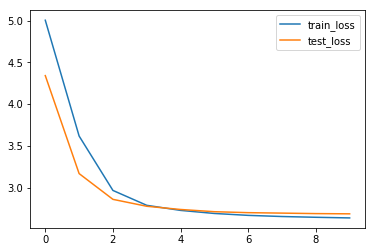

In [75]:
plot_size = n_epochs
plt.plot(list(range(plot_size)), train_losses, label='train_loss')
plt.plot(list(range(plot_size)), test_losses, label='test_loss')
plt.legend()
plt.show()

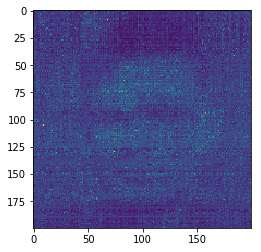

In [76]:
vals = np.array(list(range(200)))
test_d = np.transpose([np.tile(vals, len(vals)), np.repeat(vals, len(vals))])
out_pic_p = model(test_d)
plt.imshow(out_pic_p.detach().numpy()[:,1].reshape(-1,200))